<a href="https://colab.research.google.com/github/julwdo/thesis/blob/main/01_codes/01_gcolab/03_thesis_extract_additional_features_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [378]:
import pandas as pd

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

In [379]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [380]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def plot_numeric(df, feature, label_col="label"):
    weights = df.groupby(label_col)[feature].transform(lambda x: 1 / len(x))

    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df,
        x=feature,
        hue=label_col,
        bins=50,
        weights=weights,
        alpha=0.6
    )
    plt.title(f"{feature} by {label_col} (normalized)")
    plt.ylabel("Relative frequency")
    plt.show()


def plot_boolean(df, feature, label_col="label"):
    prop_df = (
        df
        .groupby(label_col)[feature]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=prop_df,
        x=feature,
        y="proportion",
        hue=label_col
    )
    plt.title(f"{feature} by {label_col}")
    plt.ylabel("Proportion")
    plt.show()

In [381]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.linear_model import LinearRegression

USER_PATTERN = r"(?<!\w)@([A-Za-z0-9_]{1,15})\b"

def cosine_sim(a, b):
    if not isinstance(a, np.ndarray) or not isinstance(b, np.ndarray):
        return np.nan
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0, 0]

def enrich_tweet_features(df):
    df = df.copy()

    # --- Basic type normalization ---
    df["created_at"] = pd.to_datetime(
        df["created_at"],
        errors="coerce",
        utc=True
    )

    df["in_reply_to_user_id"] = np.where(
        df["in_reply_to_user_id"].isna(),
        np.nan,
        "u" + df["in_reply_to_user_id"].astype("Int64").astype(str)
    )

    df[f"quote_count_missing"] = df["quote_count"].isna().astype(bool)
    df[f"reply_count_missing"] = df["reply_count"].isna().astype(bool)

    # --- Retweet target extraction ---
    df["retweeted_username"] = (
        df.loc[df["is_retweet"], "text"]
        .str.extract(USER_PATTERN, expand=False)
    )

    # --- Temporal features ---
    df["hour"] = df["created_at"].dt.hour
    df["day_of_week"] = df["created_at"].dt.dayofweek
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

    # Cyclical encoding
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

    # --- Sort for sequential features ---
    df = df.sort_values(["author_id", "created_at"])

    # --- Inter-tweet timing ---
    df["intertweet_sec"] = (
        df.groupby("author_id")["created_at"]
        .diff()
        .dt.total_seconds()
    )

    # --- Previous embedding ---
    df["embedding_prev"] = (
        df.groupby("author_id")["embedding"]
        .shift(1)
    )

    df["prev_similarity"] = df.apply(
        lambda row: cosine_sim(row["embedding"], row["embedding_prev"]),
        axis=1
    )

    # --- User centroid ---
    user_centroids = (
        df.groupby("author_id")["embedding"]
        .apply(lambda x: np.mean(np.vstack(x), axis=0))
    )

    df = df.join(
        user_centroids.rename("embedding_user_centroid"),
        on="author_id"
    )

    # --- Similarity to centroid ---
    df["centroid_similarity"] = df.apply(
        lambda row: cosine_sim(
            row["embedding"], row["embedding_user_centroid"]
        ),
        axis=1
    )

    return df

def build_user_features_from_tweets(tweet_features, user_features):

  user_features["created_at"] = pd.to_datetime(
      user_features["created_at"],
      errors="coerce",
      utc=True
      )

  # ---------- helpers ----------
  def entropy(x):
    x = x.dropna()
    if len(x) == 0:
        return 0.0

    p = x.value_counts(normalize=True)
    return -(p * np.log(p)).sum()

  def pct_within_threshold(x, threshold):
    x = x.dropna()
    if len(x) == 0:
        return 0.0
    return (x <= threshold).mean()

  def sentiment_slope(group):
    if len(group) < 2:
        return 0.0

    t = (
        group["created_at"] - group["created_at"].min()
    ).dt.total_seconds().values.reshape(-1, 1)

    y = group["sentiment"].values

    model = LinearRegression()
    model.fit(t, y)
    return model.coef_[0]

  # ---------- ordering ----------
  tf = tweet_features.sort_values(["author_id", "created_at"])

  # ---------- conversation / replies ----------
  replies = tf[tf["is_reply"] == 1]

  n_unique_users_rp = (
      replies
      .groupby("author_id")["in_reply_to_user_id"]
      .nunique()
      .rename("n_unique_users_rp")
  )

  user_entropy_rp = (
      replies
      .groupby("author_id")["in_reply_to_user_id"]
      .apply(entropy)
      .rename("user_entropy_rp")
  )

  retweets = tf[tf["is_retweet"] == 1]

  n_unique_users_rt = (
      retweets
      .groupby("author_id")["retweeted_user_id"]
      .nunique()
      .rename("n_unique_users_rt")
  )

  user_entropy_rt = (
      retweets
      .groupby("author_id")["retweeted_user_id"]
      .apply(entropy)
      .rename("user_entropy_rt")
  )

  user_conversation_features = (
      pd.concat([
          n_unique_users_rp,
          user_entropy_rp,
          n_unique_users_rt,
          user_entropy_rt
          ], axis=1)
      )

  # ---------- generic aggregation of tweet features ----------
  feature_cols = [
      'is_reply', 'is_sensitive', 'like_count', 'quote_count',
      'reply_count', 'quote_count_missing', 'reply_count_missing',
      'retweet_count', 'length',
      'num_words', 'num_sentences', 'avg_sentence_length',
      'avg_word_length', 'std_word_length', 'unique_word_ratio',
      'guiraud_index', 'repetition_ratio', 'hapax_ratio',
      'digit_ratio', 'uppercase_ratio', 'lowercase_ratio',
      'special_char_ratio', 'punctuation_ratio',
      'whitespace_ratio', 'emoji_count', 'emoji_ratio',
      'mention_count', 'contains_mention', 'url_count',
      'contains_url', 'hashtag_count', 'cashtag_count',
      'email_count', 'contains_bot_word_or_hashtag',
      'contains_ai_hashtag', 'sentiment', 'sentiment_abs',
      'sentiment_neutrality', 'sentiment_subjectivity',
      'flesch_reading_ease', 'flesch_kincaid_grade',
      'avg_syllables_per_word', 'polysyllabic_word_ratio',
      'char_entropy', 'word_entropy', 'avg_word_repetition',
      'compression_ratio', 'starts_with_emoji', 'ends_with_emoji',
      'starts_with_url', 'ends_with_url',
      'contains_pipe_or_bullet', 'contains_call_to_action',
      'contains_ai_phrase', 'function_word_ratio', 'noun_ratio',
      'verb_ratio', 'pronoun_ratio', 'adjective_ratio',
      'contains_repeated_chars', 'is_retweet', 'is_quote'
      ]

  bool_cols = tf[feature_cols].select_dtypes(include=[bool]).columns
  numeric_cols = tf[feature_cols].select_dtypes(include=[np.number]).columns

  agg_dict = {c: "mean" for c in bool_cols}
  agg_dict.update({c: ["mean", "std"] for c in numeric_cols})

  generic_aggregation = (
      tf.groupby("author_id")
      .agg(agg_dict)
      )

  generic_aggregation.columns = [
      f"{col}_{stat}" for col, stat in generic_aggregation.columns
      ]

  # ---------- temporal behavior ----------
  user_temporal_features = (
      tf
      .groupby("author_id")
      .agg(
          hour_entropy=("hour", entropy),
          dow_entropy=("day_of_week", entropy),
          is_weekend_mean=("is_weekend", "mean"),
          hour_sin_mean=("hour_sin", "mean"),
          hour_cos_mean=("hour_cos", "mean"),
          dow_sin_mean=("dow_sin", "mean"),
          dow_cos_mean=("dow_cos", "mean")
          )
      )

  user_temporal_features["hour_concentration"] = np.sqrt(
      user_temporal_features["hour_sin_mean"]**2 +
      user_temporal_features["hour_cos_mean"]**2
      )

  user_temporal_features["dow_concentration"] = np.sqrt(
      user_temporal_features["dow_sin_mean"]**2 +
      user_temporal_features["dow_cos_mean"]**2
      )

  # ---------- inter-tweet dynamics ----------
  user_delta_stats = (
      tf.groupby("author_id")["intertweet_sec"]
      .agg(
          intertweet_sec_mean="mean",
          intertweet_sec_median="median",
          intertweet_sec_std="std",
          intertweet_sec_min="min"
          )
      )

  user_delta_stats["intertweet_sec_burstiness"] = (
      user_delta_stats["intertweet_sec_std"] / user_delta_stats["intertweet_sec_mean"]
      )

  user_fast_posting = (
      tf.groupby("author_id")["intertweet_sec"]
      .agg(
          pct_within_10s=lambda x: pct_within_threshold(x, 10),
          pct_within_60s=lambda x: pct_within_threshold(x, 60),
          pct_within_5min=lambda x: pct_within_threshold(x, 300)
          )
      )

  user_intertweet_features = (
      pd.concat([user_delta_stats, user_fast_posting], axis=1)
      )

  # ---------- semantic / embedding ----------
  user_semantic_features_prev = (
      tf.groupby("author_id")["prev_similarity"]
      .agg(
          prev_similarity_mean="mean",
          prev_similarity_std="std",
          prev_similarity_min="min"
          )
      )

  user_semantic_features_centroid = (
      tf.groupby("author_id")["centroid_similarity"]
      .agg(
          centroid_similarity_mean="mean",
          centroid_similarity_max="max",
          centroid_similarity_std="std"
          )
      )

  user_embedding_features = (
      tf.groupby("author_id")["embedding"]
      .apply(lambda x: np.std(np.vstack(x), axis=0).mean())
      .rename("embedding_std_mean")
      .to_frame()
      )

  user_centroids = (
      tf[["author_id", "embedding_user_centroid"]]
      .drop_duplicates("author_id")
      .set_index("author_id")["embedding_user_centroid"]
      )

  user_features["embedding_user_centroid"] = (
      user_features["id"].map(user_centroids)
      )

  user_features["description_centroid_similarity"] = (
    user_features.apply(
        lambda row: cosine_sim(
            row["desc_embedding"],
            row["embedding_user_centroid"]
            ),
        axis=1
        )
    )

  # ---------- style & sentiment ----------
  sentiment_slope = (
      tf.groupby("author_id", group_keys=False)
      .apply(sentiment_slope, include_groups=False)
      .rename("sentiment_slope")
      )

  sentiment_pos_ratio = (
      (tf["sentiment"] > 0)
      .groupby(tf["author_id"])
      .mean()
      .rename("sentiment_pos_ratio")
      )

  sentiment_neg_ratio = (
      (tf["sentiment"] < 0)
      .groupby(tf["author_id"])
      .mean()
      .rename("sentiment_neg_ratio")
      )

  n_tweets = (
      tf.groupby("author_id")
      .size()
      .rename("n_tweets")
      )

  user_style_features = (
      pd.concat(
          [
              sentiment_slope,
              sentiment_pos_ratio,
              sentiment_neg_ratio,
              n_tweets
              ],
          axis=1
          )
      )

  user_features_from_tweets = (
      pd.concat([
          user_conversation_features,
          generic_aggregation,
          user_temporal_features,
          user_intertweet_features,
          user_semantic_features_prev,
          user_semantic_features_centroid,
          user_embedding_features,
          user_style_features
          ], axis=1)
      .add_prefix("tw_")
      .reset_index()
      )

  user_features = user_features.merge(
    user_features_from_tweets,
    left_on="id",
    right_on="author_id",
    how="left"
    )
  user_features.drop(columns="author_id", inplace=True)

  return user_features

def extract_node_features(G):
  return pd.DataFrame({
      "out_degree": dict(G.out_degree()),
      "in_degree": dict(G.in_degree()),
      "pagerank": nx.pagerank(G),
      "clustering": nx.clustering(G.to_undirected()),
      "n_neighbors": dict(nx.degree(G.to_undirected()))
      })

def extract_node_features_weighted(G):
  return pd.DataFrame({
      "out_degree": dict(G.out_degree(weight="weight")),
      "in_degree": dict(G.in_degree(weight="weight")),
      "pagerank": nx.pagerank(G, weight="weight"),
      "clustering": nx.clustering(G.to_undirected(), weight="weight"),
      "n_neighbors": dict(nx.degree(G.to_undirected()))
      })

In [382]:
def report_split(y_after, y_before, split_name):
  n = len(y_after)
  pct = n / len(y_before) * 100
  class_counts = y_after.value_counts()
  class_pct = y_after.value_counts(normalize=True) * 100

  print(f"{split_name} set: {n} rows ({pct:.2f}% of dataset)")
  for cls in class_counts.index:
    print(f"  Class {cls}: {class_counts[cls]} rows ({class_pct[cls]:.2f}%)")
  print("-" * 40)

In [383]:
import joblib

path = "/content/drive/MyDrive/twibot-22/processed"

user_features = joblib.load(f"{path}/user_features_3.joblib")
user_features.drop(columns=["desc_is_retweet", "desc_is_quote"], inplace=True)

user_features.head(1)

,id,name_length,username_length,username_name_length_ratio,description,has_name,has_username,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,ratio_digits_in_name,ratio_digits_in_username,ratio_special_chars_in_name,ratio_special_chars_in_username,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,is_protected,is_verified,created_at,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,desc_is_present,desc_length,desc_num_words,desc_num_sentences,desc_avg_sentence_length,desc_avg_word_length,desc_std_word_length,desc_unique_word_ratio,desc_guiraud_index,desc_repetition_ratio,desc_hapax_ratio,desc_digit_ratio,desc_uppercase_ratio,desc_lowercase_ratio,desc_special_char_ratio,desc_punctuation_ratio,desc_whitespace_ratio,desc_emoji_count,desc_emoji_ratio,desc_mention_count,desc_contains_mention,desc_url_count,desc_contains_url,desc_hashtag_count,desc_cashtag_count,desc_email_count,desc_contains_bot_word_or_hashtag,desc_contains_ai_hashtag,desc_sentiment,desc_sentiment_abs,desc_sentiment_neutrality,desc_sentiment_subjectivity,desc_flesch_reading_ease,desc_flesch_kincaid_grade,desc_avg_syllables_per_word,desc_polysyllabic_word_ratio,desc_char_entropy,desc_word_entropy,desc_avg_word_repetition,desc_compression_ratio,desc_starts_with_emoji,desc_ends_with_emoji,desc_starts_with_url,desc_ends_with_url,desc_contains_pipe_or_bullet,desc_contains_call_to_action,desc_contains_ai_phrase,desc_function_word_ratio,desc_noun_ratio,desc_verb_ratio,desc_pronoun_ratio,desc_adjective_ratio,desc_contains_repeated_chars,description_normalized,desc_embedding,name,username
0,u1000115670657318912,4,6,1.5,Open source tool for data & models versioning ...,True,True,False,True,True,False,0.0,0.0,0.25,0.0,3.0,1.0,2.0,2.584963,0.666667,False,False,2018-05-25 20:45:31+00:00,241981329,3488,325,79,911,10.732308,21.464615,0.093177,0.000027,0.085235,0.022649,0.261181,0.086718,0.000014,0.000001,3.264715e-07,0.000004,0,True,127.0,20.0,2.0,10.0,5.05,2.312466,0.9,4.024922,0.1,0.85,0.0,0.069307,0.930693,0.047244,0.047244,0.15748,0.0,0.0,0.0,False,1.0,True,0.0,0.0,0.0,False,False,0.765,0.765,0.235,0.375,57.095,7.78,1.65,0.1,4.407766,4.084184,1.111111,0.889764,False,False,False,False,False,True,False,0.2,0.5,0.1,0.05,0.15,False,Open source tool for data & models versioning ...,"[-0.012774717, 0.18525192, 0.16701874, -0.1026...",🦉DVC,DVCorg


In [384]:
tweet_features = joblib.load(f"{path}/tweet_features_3_0_200000.joblib")
tweet_features.drop(columns=["label", "is_present"], inplace=True)

tweet_features.head(1)

,author_id,id,text,created_at,in_reply_to_user_id,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,length,num_words,num_sentences,avg_sentence_length,avg_word_length,std_word_length,unique_word_ratio,guiraud_index,repetition_ratio,hapax_ratio,digit_ratio,uppercase_ratio,lowercase_ratio,special_char_ratio,punctuation_ratio,whitespace_ratio,emoji_count,emoji_ratio,mention_count,contains_mention,url_count,contains_url,hashtag_count,cashtag_count,email_count,contains_bot_word_or_hashtag,contains_ai_hashtag,sentiment,sentiment_abs,sentiment_neutrality,sentiment_subjectivity,flesch_reading_ease,flesch_kincaid_grade,avg_syllables_per_word,polysyllabic_word_ratio,char_entropy,word_entropy,avg_word_repetition,compression_ratio,starts_with_emoji,ends_with_emoji,starts_with_url,ends_with_url,contains_pipe_or_bullet,contains_call_to_action,contains_ai_phrase,function_word_ratio,noun_ratio,verb_ratio,pronoun_ratio,adjective_ratio,contains_repeated_chars,is_retweet,is_quote,text_normalized,embedding
0,u1001495628738957312,t1502310945158275074,Join us for a special screening of the documen...,2022-03-11 15:50:15+00:00,NaN,0,0,1,0.0,0.0,1,153,27,1,27.0,4.037037,2.71459,0.777778,4.041452,0.222222,0.666667,0.013072,0.238532,0.761468,0.111111,0.084967,0.163399,1,0.006536,3,True,1,True,1,0,0,False,False,0.636,0.636,0.364,0.285714,63.486154,7.633846,1.538462,0.074074,4.914588,4.226567,1.285714,0.986928,False,False,False,True,False,True,False,0.407407,0.37037,0.037037,0.037037,0.111111,False,False,False,Join us for a special screening of the documen...,"[0.010525476, -0.11652835, 0.047724664, 0.0785..."


In [385]:
tweet_features_1 = enrich_tweet_features(tweet_features)
tweet_features_1.head(1)

,author_id,id,text,created_at,in_reply_to_user_id,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,length,num_words,num_sentences,avg_sentence_length,avg_word_length,std_word_length,unique_word_ratio,guiraud_index,repetition_ratio,hapax_ratio,digit_ratio,uppercase_ratio,lowercase_ratio,special_char_ratio,punctuation_ratio,whitespace_ratio,emoji_count,emoji_ratio,mention_count,contains_mention,url_count,contains_url,hashtag_count,cashtag_count,email_count,contains_bot_word_or_hashtag,contains_ai_hashtag,sentiment,sentiment_abs,sentiment_neutrality,sentiment_subjectivity,flesch_reading_ease,flesch_kincaid_grade,avg_syllables_per_word,polysyllabic_word_ratio,char_entropy,word_entropy,avg_word_repetition,compression_ratio,starts_with_emoji,ends_with_emoji,starts_with_url,ends_with_url,contains_pipe_or_bullet,contains_call_to_action,contains_ai_phrase,function_word_ratio,noun_ratio,verb_ratio,pronoun_ratio,adjective_ratio,contains_repeated_chars,is_retweet,is_quote,text_normalized,embedding,quote_count_missing,reply_count_missing,retweeted_username,hour,day_of_week,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,intertweet_sec,embedding_prev,prev_similarity,embedding_user_centroid,centroid_similarity
36589,u1000115670657318912,t1496200966659522567,💗 February Heartbeat is out! 💗\n\nThis month y...,2022-02-22 19:11:23+00:00,NaN,0,0,7,NaN,NaN,2,233,31,4,7.75,5.032258,2.375736,0.903226,5.028948,0.096774,0.806452,0.0,0.211765,0.788235,0.133047,0.051502,0.137339,7,0.030043,0,False,2,True,0,0,0,False,False,0.9873,0.9873,0.0127,0.75,53.245833,8.4825,1.6875,0.193548,5.046403,4.760648,1.107143,0.957082,True,False,False,True,False,False,False,0.225806,0.354839,0.096774,0.032258,0.225806,False,False,False,:growing_heart: February Heartbeat is out ! :g...,"[0.1264794, -0.09787777, 0.17991398, 0.0306944...",True,True,NaN,19,1,0,-0.965926,0.258819,0.781831,0.62349,NaN,NaN,NaN,"[0.047334157, -0.007018438, 0.14205173, 0.0071...",0.895809


In [386]:
username_to_id = dict(zip(user_features["username"], user_features["id"]))

tweet_features_2 = tweet_features_1.copy()

tweet_features_2["retweeted_user_id"] = tweet_features_2["retweeted_username"].map(username_to_id)
tweet_features_2.head(1)

,author_id,id,text,created_at,in_reply_to_user_id,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,length,num_words,num_sentences,avg_sentence_length,avg_word_length,std_word_length,unique_word_ratio,guiraud_index,repetition_ratio,hapax_ratio,digit_ratio,uppercase_ratio,lowercase_ratio,special_char_ratio,punctuation_ratio,whitespace_ratio,emoji_count,emoji_ratio,mention_count,contains_mention,url_count,contains_url,hashtag_count,cashtag_count,email_count,contains_bot_word_or_hashtag,contains_ai_hashtag,sentiment,sentiment_abs,sentiment_neutrality,sentiment_subjectivity,flesch_reading_ease,flesch_kincaid_grade,avg_syllables_per_word,polysyllabic_word_ratio,char_entropy,word_entropy,avg_word_repetition,compression_ratio,starts_with_emoji,ends_with_emoji,starts_with_url,ends_with_url,contains_pipe_or_bullet,contains_call_to_action,contains_ai_phrase,function_word_ratio,noun_ratio,verb_ratio,pronoun_ratio,adjective_ratio,contains_repeated_chars,is_retweet,is_quote,text_normalized,embedding,quote_count_missing,reply_count_missing,retweeted_username,hour,day_of_week,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,intertweet_sec,embedding_prev,prev_similarity,embedding_user_centroid,centroid_similarity,retweeted_user_id
36589,u1000115670657318912,t1496200966659522567,💗 February Heartbeat is out! 💗\n\nThis month y...,2022-02-22 19:11:23+00:00,NaN,0,0,7,NaN,NaN,2,233,31,4,7.75,5.032258,2.375736,0.903226,5.028948,0.096774,0.806452,0.0,0.211765,0.788235,0.133047,0.051502,0.137339,7,0.030043,0,False,2,True,0,0,0,False,False,0.9873,0.9873,0.0127,0.75,53.245833,8.4825,1.6875,0.193548,5.046403,4.760648,1.107143,0.957082,True,False,False,True,False,False,False,0.225806,0.354839,0.096774,0.032258,0.225806,False,False,False,:growing_heart: February Heartbeat is out ! :g...,"[0.1264794, -0.09787777, 0.17991398, 0.0306944...",True,True,NaN,19,1,0,-0.965926,0.258819,0.781831,0.62349,NaN,NaN,NaN,"[0.047334157, -0.007018438, 0.14205173, 0.0071...",0.895809,NaN


In [387]:
if tweet_features_2.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features_2.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features_2.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                         Missing Count  Missing Percentage
in_reply_to_user_id             167845             83.9225
quote_count                     151545             75.7725
reply_count                     151545             75.7725
avg_word_length                      7              0.0035
std_word_length                      7              0.0035
unique_word_ratio                    7              0.0035
guiraud_index                        7              0.0035
repetition_ratio                     7              0.0035
hapax_ratio                          7              0.0035
polysyllabic_word_ratio              7              0.0035
word_entropy                         7              0.0035
avg_word_repetition                  7              0.0035
function_word_ratio                  7              0.0035
noun_ratio                           7              0.0035
verb_ratio                           7            

In [388]:
tweet_features_2[["is_reply", "is_sensitive"]] = (
    tweet_features_2[["is_reply", "is_sensitive"]].astype(bool)
)

In [389]:
user_features_1 = build_user_features_from_tweets(tweet_features_2, user_features)
user_features_1.head(1)

,id,name_length,username_length,username_name_length_ratio,description,has_name,has_username,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,ratio_digits_in_name,ratio_digits_in_username,ratio_special_chars_in_name,ratio_special_chars_in_username,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,is_protected,is_verified,created_at,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,desc_is_present,desc_length,desc_num_words,desc_num_sentences,desc_avg_sentence_length,desc_avg_word_length,desc_std_word_length,desc_unique_word_ratio,desc_guiraud_index,desc_repetition_ratio,desc_hapax_ratio,desc_digit_ratio,desc_uppercase_ratio,desc_lowercase_ratio,desc_special_char_ratio,desc_punctuation_ratio,desc_whitespace_ratio,desc_emoji_count,desc_emoji_ratio,desc_mention_count,desc_contains_mention,desc_url_count,desc_contains_url,desc_hashtag_count,desc_cashtag_count,desc_email_count,desc_contains_bot_word_or_hashtag,desc_contains_ai_hashtag,desc_sentiment,desc_sentiment_abs,desc_sentiment_neutrality,desc_sentiment_subjectivity,desc_flesch_reading_ease,desc_flesch_kincaid_grade,desc_avg_syllables_per_word,desc_polysyllabic_word_ratio,desc_char_entropy,desc_word_entropy,desc_avg_word_repetition,desc_compression_ratio,desc_starts_with_emoji,desc_ends_with_emoji,desc_starts_with_url,desc_ends_with_url,desc_contains_pipe_or_bullet,desc_contains_call_to_action,desc_contains_ai_phrase,desc_function_word_ratio,desc_noun_ratio,desc_verb_ratio,desc_pronoun_ratio,desc_adjective_ratio,desc_contains_repeated_chars,description_normalized,desc_embedding,name,username,embedding_user_centroid,description_centroid_similarity,tw_n_unique_users_rp,tw_user_entropy_rp,tw_n_unique_users_rt,tw_user_entropy_rt,tw_is_reply_mean,tw_is_sensitive_mean,tw_quote_count_missing_mean,tw_reply_count_missing_mean,tw_contains_mention_mean,tw_contains_url_mean,tw_contains_bot_word_or_hashtag_mean,tw_contains_ai_hashtag_mean,tw_starts_with_emoji_mean,tw_ends_with_emoji_mean,tw_starts_with_url_mean,tw_ends_with_url_mean,tw_contains_pipe_or_bullet_mean,tw_contains_call_to_action_mean,tw_contains_ai_phrase_mean,tw_contains_repeated_chars_mean,tw_is_retweet_mean,tw_is_quote_mean,tw_like_count_mean,tw_like_count_std,tw_quote_count_mean,tw_quote_count_std,tw_reply_count_mean,tw_reply_count_std,tw_retweet_count_mean,tw_retweet_count_std,tw_length_mean,tw_length_std,tw_num_words_mean,tw_num_words_std,tw_num_sentences_mean,tw_num_sentences_std,tw_avg_sentence_length_mean,tw_avg_sentence_length_std,tw_avg_word_length_mean,tw_avg_word_length_std,tw_std_word_length_mean,tw_std_word_length_std,tw_unique_word_ratio_mean,tw_unique_word_ratio_std,tw_guiraud_index_mean,tw_guiraud_index_std,tw_repetition_ratio_mean,tw_repetition_ratio_std,tw_hapax_ratio_mean,tw_hapax_ratio_std,tw_digit_ratio_mean,tw_digit_ratio_std,tw_uppercase_ratio_mean,tw_uppercase_ratio_std,tw_lowercase_ratio_mean,tw_lowercase_ratio_std,tw_special_char_ratio_mean,tw_special_char_ratio_std,tw_punctuation_ratio_mean,tw_punctuation_ratio_std,tw_whitespace_ratio_mean,tw_whitespace_ratio_std,tw_emoji_count_mean,tw_emoji_count_std,tw_emoji_ratio_mean,tw_emoji_ratio_std,tw_mention_count_mean,tw_mention_count_std,tw_url_count_mean,tw_url_count_std,tw_hashtag_count_mean,tw_hashtag_count_std,tw_cashtag_count_mean,tw_cashtag_count_std,tw_email_count_mean,tw_email_count_std,tw_sentiment_mean,tw_sentiment_std,tw_sentiment_abs_mean,tw_sentiment_abs_std,tw_sentiment_neutrality_mean,tw_sentiment_neutrality_std,tw_sentiment_subjectivity_mean,tw_sentiment_subjectivity_std,tw_flesch_reading_ease_mean,tw_flesch_reading_ease_std,tw_flesch_kincaid_grade_mean,tw_flesch_kincaid_grade_s

In [390]:
import networkx as nx

edges_rt = (
    tweet_features_2[tweet_features_2["is_retweet"]]
    .dropna(subset=["retweeted_user_id"])
    .groupby(["author_id", "retweeted_user_id"])
    .size()
    .reset_index(name="weight")
    )

G_rt = nx.DiGraph()
G_rt.add_weighted_edges_from(edges_rt.values)

rt_network_features = (
    extract_node_features_weighted(G_rt)
    .reset_index()
    .rename(columns={"index": "id"})
    )
rt_network_features.rename(columns={c: f"rt_{c}" for c in rt_network_features.columns if c != "id"}, inplace=True)
rt_network_features.head(1)

,id,rt_out_degree,rt_in_degree,rt_pagerank,rt_clustering,rt_n_neighbors
0,u1000115670657318912,2,0,0.00005,0.0,2


In [391]:
edges_rp = (
    tweet_features_2[tweet_features_2["is_reply"]]
    .dropna(subset=["in_reply_to_user_id"])
    .groupby(["author_id", "in_reply_to_user_id"])
    .size()
    .reset_index(name="weight")
    )

G_rp = nx.DiGraph()
G_rp.add_weighted_edges_from(edges_rp.values)

rp_network_features = (
    extract_node_features_weighted(G_rp)
    .reset_index()
    .rename(columns={"index": "id"})
    )
rp_network_features.rename(columns={c: f"rp_{c}" for c in rp_network_features.columns if c != "id"}, inplace=True)
rp_network_features.head(1)

,id,rp_out_degree,rp_in_degree,rp_pagerank,rp_clustering,rp_n_neighbors
0,u1000115670657318912,1,0,0.000028,0.0,1


In [392]:
edges = pd.read_parquet(f"{path}/edges_filtered.parquet", engine='pyarrow')
edges.head(1)

,target_id,source_id,relation
0,u1000115670657318912,u894057794,followers


In [393]:
edges["relation"].unique()

array(['followers', 'following'], dtype=object)

In [394]:
edges_fw = (
    edges
    .loc[edges["relation"] == "following",
         ["source_id", "target_id"]]
    .reset_index(drop=True)
    )

G_fw = nx.DiGraph()
G_fw.add_edges_from(edges_fw.values)

fw_network_features = (
    extract_node_features(G_fw)
    .reset_index()
    .rename(columns={"index": "id"})
    )
fw_network_features.rename(columns={c: f"fw_{c}" for c in fw_network_features.columns if c != "id"}, inplace=True)
fw_network_features.head()

,id,fw_out_degree,fw_in_degree,fw_pagerank,fw_clustering,fw_n_neighbors
0,u55857505,210,2,0.000026,0.007583,211
1,u1000115670657318912,0,7,0.000025,0.238095,7
2,u398087684,192,14,0.000029,0.008383,206
3,u147491637,151,2,0.000024,0.020309,151
4,u246939962,179,58,0.000037,0.026343,233


In [395]:
rt_network_features["rt_out_in_ratio"] = rt_network_features["rt_out_degree"] / (rt_network_features["rt_in_degree"] + 1)
rp_network_features["rp_out_in_ratio"] = rp_network_features["rp_out_degree"] / (rp_network_features["rp_in_degree"] + 1)
fw_network_features["fw_out_in_ratio"] = fw_network_features["fw_out_degree"] / (fw_network_features["fw_in_degree"] + 1)

In [396]:
user_features_2 = (
    user_features_1
    .merge(rt_network_features, on="id", how="left")
    .merge(rp_network_features, on="id", how="left")
    .merge(fw_network_features, on="id", how="left")
    )
user_features_2.head(1)

,id,name_length,username_length,username_name_length_ratio,description,has_name,has_username,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,ratio_digits_in_name,ratio_digits_in_username,ratio_special_chars_in_name,ratio_special_chars_in_username,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,is_protected,is_verified,created_at,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,desc_is_present,desc_length,desc_num_words,desc_num_sentences,desc_avg_sentence_length,desc_avg_word_length,desc_std_word_length,desc_unique_word_ratio,desc_guiraud_index,desc_repetition_ratio,desc_hapax_ratio,desc_digit_ratio,desc_uppercase_ratio,desc_lowercase_ratio,desc_special_char_ratio,desc_punctuation_ratio,desc_whitespace_ratio,desc_emoji_count,desc_emoji_ratio,desc_mention_count,desc_contains_mention,desc_url_count,desc_contains_url,desc_hashtag_count,desc_cashtag_count,desc_email_count,desc_contains_bot_word_or_hashtag,desc_contains_ai_hashtag,desc_sentiment,desc_sentiment_abs,desc_sentiment_neutrality,desc_sentiment_subjectivity,desc_flesch_reading_ease,desc_flesch_kincaid_grade,desc_avg_syllables_per_word,desc_polysyllabic_word_ratio,desc_char_entropy,desc_word_entropy,desc_avg_word_repetition,desc_compression_ratio,desc_starts_with_emoji,desc_ends_with_emoji,desc_starts_with_url,desc_ends_with_url,desc_contains_pipe_or_bullet,desc_contains_call_to_action,desc_contains_ai_phrase,desc_function_word_ratio,desc_noun_ratio,desc_verb_ratio,desc_pronoun_ratio,desc_adjective_ratio,desc_contains_repeated_chars,description_normalized,desc_embedding,name,username,embedding_user_centroid,description_centroid_similarity,tw_n_unique_users_rp,tw_user_entropy_rp,tw_n_unique_users_rt,tw_user_entropy_rt,tw_is_reply_mean,tw_is_sensitive_mean,tw_quote_count_missing_mean,tw_reply_count_missing_mean,tw_contains_mention_mean,tw_contains_url_mean,tw_contains_bot_word_or_hashtag_mean,tw_contains_ai_hashtag_mean,tw_starts_with_emoji_mean,tw_ends_with_emoji_mean,tw_starts_with_url_mean,tw_ends_with_url_mean,tw_contains_pipe_or_bullet_mean,tw_contains_call_to_action_mean,tw_contains_ai_phrase_mean,tw_contains_repeated_chars_mean,tw_is_retweet_mean,tw_is_quote_mean,tw_like_count_mean,tw_like_count_std,tw_quote_count_mean,tw_quote_count_std,tw_reply_count_mean,tw_reply_count_std,tw_retweet_count_mean,tw_retweet_count_std,tw_length_mean,tw_length_std,tw_num_words_mean,tw_num_words_std,tw_num_sentences_mean,tw_num_sentences_std,tw_avg_sentence_length_mean,tw_avg_sentence_length_std,tw_avg_word_length_mean,tw_avg_word_length_std,tw_std_word_length_mean,tw_std_word_length_std,tw_unique_word_ratio_mean,tw_unique_word_ratio_std,tw_guiraud_index_mean,tw_guiraud_index_std,tw_repetition_ratio_mean,tw_repetition_ratio_std,tw_hapax_ratio_mean,tw_hapax_ratio_std,tw_digit_ratio_mean,tw_digit_ratio_std,tw_uppercase_ratio_mean,tw_uppercase_ratio_std,tw_lowercase_ratio_mean,tw_lowercase_ratio_std,tw_special_char_ratio_mean,tw_special_char_ratio_std,tw_punctuation_ratio_mean,tw_punctuation_ratio_std,tw_whitespace_ratio_mean,tw_whitespace_ratio_std,tw_emoji_count_mean,tw_emoji_count_std,tw_emoji_ratio_mean,tw_emoji_ratio_std,tw_mention_count_mean,tw_mention_count_std,tw_url_count_mean,tw_url_count_std,tw_hashtag_count_mean,tw_hashtag_count_std,tw_cashtag_count_mean,tw_cashtag_count_std,tw_email_count_mean,tw_email_count_std,tw_sentiment_mean,tw_sentiment_std,tw_sentiment_abs_mean,tw_sentiment_abs_std,tw_sentiment_neutrality_mean,tw_sentiment_neutrality_std,tw_sentiment_subjectivity_mean,tw_sentiment_subjectivity_std,tw_flesch_reading_ease_mean,tw_flesch_reading_ease_std,tw_flesch_kincaid_grade_mean,tw_flesch_kincaid_grade_s

In [397]:
user_features_2["rt_outside_subset_flag"] = (  # some users retweet only users from outside of the subset
    (user_features_2["tw_is_retweet_mean"] != 0) &
    (user_features_2["rt_out_degree"].isna())
).astype(bool)

user_features_2["in_fw_network"] = user_features_2["id"].isin(fw_network_features["id"]).astype(bool)  # some users are not in the following network

In [398]:
joblib.dump(user_features_2, f"{path}/user_features_4.joblib")

['/content/drive/MyDrive/twibot-22/processed/user_features_4.joblib']

In [438]:
#pd.set_option("display.max_rows", None)
pd.reset_option("display.max_rows")

In [400]:
user_features_2 = user_features_2[user_features_2["id"].isin(tweet_features["author_id"].unique())]
user_features_2.shape

(18911, 258)

In [401]:
if user_features_2.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = user_features_2.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / user_features_2.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                                Missing Count  Missing Percentage
desc_length                               624            3.299667
desc_num_words                            624            3.299667
desc_num_sentences                        624            3.299667
desc_avg_sentence_length                  624            3.299667
desc_avg_word_length                      677            3.579927
desc_std_word_length                      677            3.579927
desc_unique_word_ratio                    677            3.579927
desc_guiraud_index                        677            3.579927
desc_repetition_ratio                     677            3.579927
desc_hapax_ratio                          677            3.579927
desc_digit_ratio                          624            3.299667
desc_uppercase_ratio                      663            3.505896
desc_lowercase_ratio                      663            3.505896
desc_specia

In [402]:
user_features_3 = user_features_2.copy()
user_features_3 = user_features_3.fillna(0)

In [403]:
if user_features_3.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = user_features_3.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / user_features_3.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [404]:
from sklearn.model_selection import train_test_split

exclude_cols = [
    "id",
    "description",
    "created_at",
    "description_normalized",
#    "desc_embedding",
    "embedding_user_centroid",
    "name",
    "username",
    "label"
    ]

X = user_features_3.drop(columns=exclude_cols)
y = user_features_3["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
    )

report_split(y_train, y, "Training")
report_split(y_test, y, "Test")

Training set: 17019 rows (90.00% of dataset)
  Class 0: 15728 rows (92.41%)
  Class 1: 1291 rows (7.59%)
----------------------------------------
Test set: 1892 rows (10.00% of dataset)
  Class 0: 1749 rows (92.44%)
  Class 1: 143 rows (7.56%)
----------------------------------------


In [405]:
X_train_desc = np.vstack(X_train["desc_embedding"].values)
X_test_desc = np.vstack(X_test["desc_embedding"].values)
# shape: (n_users, 768)

In [406]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=100,   # try 50–100
    random_state=42
)

X_train_desc_pca = pca.fit_transform(X_train_desc)
X_test_desc_pca = pca.transform(X_test_desc)

In [407]:
pca_cols = [f"desc_pca_{i}" for i in range(X_train_desc_pca.shape[1])]

desc_pca_train = pd.DataFrame(
    X_train_desc_pca,
    index=X_train.index,
    columns=pca_cols
)

desc_pca_test = pd.DataFrame(
    X_test_desc_pca,
    index=X_test.index,
    columns=pca_cols
)

In [408]:
X_train = X_train.join(desc_pca_train, how="left").drop(columns="desc_embedding")
X_test = X_test.join(desc_pca_test, how="left").drop(columns="desc_embedding")

In [415]:
X_train.head(1)

,name_length,username_length,username_name_length_ratio,has_name,has_username,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,ratio_digits_in_name,ratio_digits_in_username,ratio_special_chars_in_name,ratio_special_chars_in_username,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,desc_is_present,desc_length,desc_num_words,desc_num_sentences,desc_avg_sentence_length,desc_avg_word_length,desc_std_word_length,desc_unique_word_ratio,desc_guiraud_index,desc_repetition_ratio,desc_hapax_ratio,desc_digit_ratio,desc_uppercase_ratio,desc_lowercase_ratio,desc_special_char_ratio,desc_punctuation_ratio,desc_whitespace_ratio,desc_emoji_count,desc_emoji_ratio,desc_mention_count,desc_contains_mention,desc_url_count,desc_contains_url,desc_hashtag_count,desc_cashtag_count,desc_email_count,desc_contains_bot_word_or_hashtag,desc_contains_ai_hashtag,desc_sentiment,desc_sentiment_abs,desc_sentiment_neutrality,desc_sentiment_subjectivity,desc_flesch_reading_ease,desc_flesch_kincaid_grade,desc_avg_syllables_per_word,desc_polysyllabic_word_ratio,desc_char_entropy,desc_word_entropy,desc_avg_word_repetition,desc_compression_ratio,desc_starts_with_emoji,desc_ends_with_emoji,desc_starts_with_url,desc_ends_with_url,desc_contains_pipe_or_bullet,desc_contains_call_to_action,desc_contains_ai_phrase,desc_function_word_ratio,desc_noun_ratio,desc_verb_ratio,desc_pronoun_ratio,desc_adjective_ratio,desc_contains_repeated_chars,description_centroid_similarity,tw_n_unique_users_rp,tw_user_entropy_rp,tw_n_unique_users_rt,tw_user_entropy_rt,tw_is_reply_mean,tw_is_sensitive_mean,tw_quote_count_missing_mean,tw_reply_count_missing_mean,tw_contains_mention_mean,tw_contains_url_mean,tw_contains_bot_word_or_hashtag_mean,tw_contains_ai_hashtag_mean,tw_starts_with_emoji_mean,tw_ends_with_emoji_mean,tw_starts_with_url_mean,tw_ends_with_url_mean,tw_contains_pipe_or_bullet_mean,tw_contains_call_to_action_mean,tw_contains_ai_phrase_mean,tw_contains_repeated_chars_mean,tw_is_retweet_mean,tw_is_quote_mean,tw_like_count_mean,tw_like_count_std,tw_quote_count_mean,tw_quote_count_std,tw_reply_count_mean,tw_reply_count_std,tw_retweet_count_mean,tw_retweet_count_std,tw_length_mean,tw_length_std,tw_num_words_mean,tw_num_words_std,tw_num_sentences_mean,tw_num_sentences_std,tw_avg_sentence_length_mean,tw_avg_sentence_length_std,tw_avg_word_length_mean,tw_avg_word_length_std,tw_std_word_length_mean,tw_std_word_length_std,tw_unique_word_ratio_mean,tw_unique_word_ratio_std,tw_guiraud_index_mean,tw_guiraud_index_std,tw_repetition_ratio_mean,tw_repetition_ratio_std,tw_hapax_ratio_mean,tw_hapax_ratio_std,tw_digit_ratio_mean,tw_digit_ratio_std,tw_uppercase_ratio_mean,tw_uppercase_ratio_std,tw_lowercase_ratio_mean,tw_lowercase_ratio_std,tw_special_char_ratio_mean,tw_special_char_ratio_std,tw_punctuation_ratio_mean,tw_punctuation_ratio_std,tw_whitespace_ratio_mean,tw_whitespace_ratio_std,tw_emoji_count_mean,tw_emoji_count_std,tw_emoji_ratio_mean,tw_emoji_ratio_std,tw_mention_count_mean,tw_mention_count_std,tw_url_count_mean,tw_url_count_std,tw_hashtag_count_mean,tw_hashtag_count_std,tw_cashtag_count_mean,tw_cashtag_count_std,tw_email_count_mean,tw_email_count_std,tw_sentiment_mean,tw_sentiment_std,tw_sentiment_abs_mean,tw_sentiment_abs_std,tw_sentiment_neutrality_mean,tw_sentiment_neutrality_std,tw_sentiment_subjectivity_mean,tw_sentiment_subjectivity_std,tw_flesch_reading_ease_mean,tw_flesch_reading_ease_std,tw_flesch_kincaid_grade_mean,tw_flesch_kincaid_grade_std,tw_avg_syllables_per_word_mean,tw_avg_syllables_per_word_std,tw_polysyllabic_word_ratio_mean,tw_polysylla

In [416]:
variances = X_train.var()

low_variance = variances[variances < 0.001].sort_values()

print("Features with variance < 0.001:")
for feature, var in low_variance.items():
    print(f"{feature}: {var:.6f}")

Features with variance < 0.001:
has_name: 0.000000
has_username: 0.000000
tw_contains_ai_phrase_mean: 0.000000
listed_rate: 0.000000
fw_pagerank: 0.000000
following_rate: 0.000000
rp_pagerank: 0.000000
rt_pagerank: 0.000000
tweet_rate: 0.000000
rp_clustering: 0.000000
follower_rate: 0.000002
rt_clustering: 0.000048
desc_contains_ai_phrase: 0.000118
tw_contains_bot_word_or_hashtag_mean: 0.000139
tw_whitespace_ratio_std: 0.000147
tw_digit_ratio_std: 0.000152
tw_digit_ratio_mean: 0.000304
tw_whitespace_ratio_mean: 0.000354
tw_emoji_ratio_std: 0.000401
tw_punctuation_ratio_std: 0.000405
tw_contains_ai_hashtag_mean: 0.000502
desc_digit_ratio: 0.000579
desc_emoji_ratio: 0.000633
tw_starts_with_url_mean: 0.000673
desc_contains_ai_hashtag: 0.000705
tw_punctuation_ratio_mean: 0.000760
tw_sentiment_slope: 0.000770
tw_emoji_ratio_mean: 0.000843
tw_pronoun_ratio_std: 0.000848
tw_centroid_similarity_std: 0.000878
tw_special_char_ratio_std: 0.000906


In [417]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_bool_cols = X_train.select_dtypes(include=[np.number, 'bool']).columns

numeric_bool_pipeline = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.001)),  # remove features with variance < 0.001
    ("model_sel", SelectFromModel(
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        threshold="median"  # keep features above median importance
    ))
])

preprocessor = ColumnTransformer([
    ("numeric_bool_pipeline", numeric_bool_pipeline, numeric_bool_cols)
    ], remainder="passthrough")

# Fit on training set
preprocessor.fit(X_train, y_train)

# Transform train/test sets
X_train_selected = preprocessor.transform(X_train)
X_test_selected = preprocessor.transform(X_test)

In [455]:
numeric_bool_pipeline_fitted = preprocessor.named_transformers_['numeric_bool_pipeline']

var_mask = numeric_bool_pipeline_fitted.named_steps['var_thresh'].get_support()
cols_after_var = numeric_bool_cols[var_mask]

sfm = numeric_bool_pipeline_fitted.named_steps['model_sel']
model_mask = sfm.get_support()
numeric_bool_cols_selected = cols_after_var[model_mask]

all_selected_cols = list(numeric_bool_cols_selected)

X_train_selected_df = pd.DataFrame(X_train_selected, columns=all_selected_cols, index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=all_selected_cols, index=X_test.index)

numeric_cols = X.select_dtypes(include=[np.number]).columns
bool_cols = X.select_dtypes(include=['bool']).columns

# Restore feature types
numeric_cols_selected = [col for col in numeric_bool_cols_selected if col in numeric_cols]
bool_cols_selected = [col for col in numeric_bool_cols_selected if col in bool_cols]

X_train_selected_df[numeric_cols_selected] = X_train_selected_df[numeric_cols_selected].astype(float)
X_test_selected_df[numeric_cols_selected] = X_test_selected_df[numeric_cols_selected].astype(float)

X_train_selected_df[bool_cols_selected] = X_train_selected_df[bool_cols_selected].astype(int)
X_test_selected_df[bool_cols_selected] = X_test_selected_df[bool_cols_selected].astype(int)

In [456]:
# Check feature importances
importances = sfm.estimator_.feature_importances_[model_mask]

feat_importances = pd.DataFrame({
    "feature": numeric_bool_cols_selected,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importances)

                         feature  importance
6                followers_count    0.383489
9                    tweet_count    0.053005
7                following_count    0.051556
97                    desc_pca_0    0.037990
32        desc_compression_ratio    0.027763
..                           ...         ...
92    tw_centroid_similarity_max    0.000528
146                  desc_pca_79    0.000526
47   tw_avg_sentence_length_mean    0.000525
50       tw_std_word_length_mean    0.000509
150                  desc_pca_85    0.000507

[159 rows x 2 columns]


In [457]:
X_train_selected_df.head(1)

,username_name_length_ratio,has_location,has_bot_word_in_name,username_entropy,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,desc_length,desc_num_words,desc_avg_sentence_length,desc_std_word_length,desc_lowercase_ratio,desc_whitespace_ratio,desc_emoji_count,desc_hashtag_count,desc_contains_bot_word_or_hashtag,desc_sentiment,desc_sentiment_neutrality,desc_sentiment_subjectivity,desc_flesch_reading_ease,desc_flesch_kincaid_grade,desc_char_entropy,desc_word_entropy,desc_compression_ratio,desc_function_word_ratio,desc_pronoun_ratio,description_centroid_similarity,tw_user_entropy_rp,tw_contains_call_to_action_mean,tw_is_quote_mean,tw_like_count_mean,tw_reply_count_mean,tw_retweet_count_mean,tw_length_mean,tw_num_words_mean,tw_num_words_std,tw_num_sentences_mean,tw_num_sentences_std,tw_avg_sentence_length_mean,tw_avg_word_length_mean,tw_avg_word_length_std,tw_std_word_length_mean,tw_guiraud_index_mean,tw_hapax_ratio_mean,tw_uppercase_ratio_mean,tw_lowercase_ratio_mean,tw_emoji_count_mean,tw_mention_count_mean,tw_mention_count_std,tw_hashtag_count_mean,tw_hashtag_count_std,tw_cashtag_count_mean,tw_cashtag_count_std,tw_sentiment_mean,tw_sentiment_std,tw_sentiment_neutrality_mean,tw_sentiment_neutrality_std,tw_flesch_reading_ease_mean,tw_flesch_kincaid_grade_std,tw_avg_syllables_per_word_mean,tw_polysyllabic_word_ratio_mean,tw_polysyllabic_word_ratio_std,tw_char_entropy_mean,tw_char_entropy_std,tw_word_entropy_mean,tw_compression_ratio_mean,tw_compression_ratio_std,tw_function_word_ratio_mean,tw_verb_ratio_mean,tw_adjective_ratio_std,tw_dow_entropy,tw_is_weekend_mean,tw_hour_cos_mean,tw_dow_sin_mean,tw_hour_concentration,tw_dow_concentration,tw_intertweet_sec_mean,tw_intertweet_sec_median,tw_intertweet_sec_std,tw_intertweet_sec_min,tw_intertweet_sec_burstiness,tw_prev_similarity_mean,tw_prev_similarity_min,tw_centroid_similarity_max,tw_sentiment_pos_ratio,rt_out_degree,rp_in_degree,rp_n_neighbors,desc_pca_0,desc_pca_1,desc_pca_2,desc_pca_3,desc_pca_4,desc_pca_7,desc_pca_8,desc_pca_9,desc_pca_10,desc_pca_11,desc_pca_14,desc_pca_16,desc_pca_17,desc_pca_18,desc_pca_19,desc_pca_23,desc_pca_24,desc_pca_25,desc_pca_26,desc_pca_27,desc_pca_29,desc_pca_31,desc_pca_32,desc_pca_33,desc_pca_36,desc_pca_38,desc_pca_39,desc_pca_40,desc_pca_41,desc_pca_42,desc_pca_43,desc_pca_45,desc_pca_46,desc_pca_48,desc_pca_50,desc_pca_56,desc_pca_57,desc_pca_61,desc_pca_62,desc_pca_63,desc_pca_66,desc_pca_67,desc_pca_68,desc_pca_69,desc_pca_72,desc_pca_73,desc_pca_74,desc_pca_76,desc_pca_78,desc_pca_79,desc_pca_81,desc_pca_82,desc_pca_84,desc_pca_85,desc_pca_86,desc_pca_87,desc_pca_89,desc_pca_92,desc_pca_93,desc_pca_96,desc_pca_97,desc_pca_98
2170,0.666667,1,0,3.0,0,404231450.0,1793.0,318.0,28.0,1004.0,0.177356,0.000099,0.15064,0.015616,0.559955,0.027888,148.0,17.0,8.5,3.097046,0.814159,0.121622,0.0,1.0,0,0.0,1.0,0.0,-19.431765,20.192941,4.670686,3.969816,0.966216,0.0,0.0,0.127575,1.039721,0.05,0.0,2.15,0.0,5.5,159.45,25.45,7.870498,1.75,0.910465,17.533333,4.605923,0.438203,2.502601,4.409809,0.798363,0.167501,0.832499,0.55,1.7,1.49032,0.1,0.447214,0.0,0.0,0.540985,0.39182,0.459015,0.39182,55.011235,4.036067,1.566752,0.137478,0.077834,4.637133,0.110303,4.362292,0.906554,0.089609,0.229246,0.138341,0.066379,1.613794,0.05,-0.690758,0.168995,0.825907,0.294362,814461.157895,620526.0,854502.014415,0.0,1.049162,0.827995,0.747431,0.941987,0.7,0.0,2.0,4.0,0.468337,0.125963,-0.194381,0.372213,-0.103674,0.366886,-0.612522,0.062414,0.336008,-0.091702,0.019615,0.168563,-0.094025,0.099578,-0.252865,-0.017038,0.145199,-0.552205,0.351998,-0.105834,0.255085,0.087467,0.126089,-0.106309,-0.171271,-0.037043,0.239199,-0.497975,0.195295,-0.238426,-0.510847,0.371966,0.237949,-0.16735,0.013388,0.06317,-0.483739,-0.186213,-0.121557,-0.001651,0.244854,0.228495,-0.063692,0.225775,0.088104,0.162

In [458]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(
    sampling_strategy=0.5,
    random_state=42,
    k_neighbors=3
)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected_df, y_train)

In [459]:
y_train_resampled.value_counts(normalize=True)

,proportion
label,
0,0.666667
1,0.333333


In [462]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

xgb_model.fit(X_train_selected_df, y_train)

y_pred_xgb = xgb_model.predict(X_test_selected_df)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("XGBoost F1:", f1_xgb)

XGBoost F1: 0.4418604651162791


In [ ]:
#XGBoost F1: 0.4083333333333333 (oversampling 0.5, pos weight) (0.4689655172413793, np.float64(0.2704081632653061))
# same settings, no embedding pca: 0.3981042654028436
# same settings, no network feats: XGBoost F1: 0.4074074074074074 (0.47509578544061304, np.float64(0.3255102040816326))
# same settings, embedding pca only: XGBoost F1: 0.30927835051546393
# same settings, no fw and rt network feats: XGBoost F1: 0.41284403669724773 (0.45098039215686275, np.float64(0.2520408163265306))
# same settings, raw embeddings - no pca: XGBoost F1: 0.4 (0.46715328467153283, np.float64(0.2704081632653061))
# same settings, selected features: XGBoost F1: 0.3964757709251101 (0.41702127659574467, np.float64(0.4724489795918367))
# only desc_, tw_ and rp_ fetures: XGBoost F1: 0.29441624365482233
# train on only n_tweets > 2: 0.37320574162679426
# considering only n_tweets > 2: 0.2953020134228188

In [463]:
import numpy as np
from sklearn.metrics import f1_score

probs = xgb_model.predict_proba(X_test_selected_df)[:, 1]

thresholds = np.linspace(0.05, 0.95, 50)
f1s = [f1_score(y_test, probs >= t) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
max(f1s), best_t

(0.46096654275092935, np.float64(0.4540816326530612))

In [464]:
import pandas as pd

probs = xgb_model.predict_proba(X_test_selected_df)[:, 1]
y_pred = (probs >= best_t).astype(int)  # or 0.5 if you haven’t tuned yet

errors = X_test_selected_df.copy()
errors["y_true"] = y_test.values
errors["y_pred"] = y_pred
errors["prob"] = probs

errors["error_type"] = "correct"
errors.loc[(errors.y_true == 1) & (errors.y_pred == 0), "error_type"] = "FN"
errors.loc[(errors.y_true == 0) & (errors.y_pred == 1), "error_type"] = "FP"
errors.loc[(errors.y_true == 0) & (errors.y_pred == 0), "error_type"] = "TN"
errors.loc[(errors.y_true == 1) & (errors.y_pred == 1), "error_type"] = "TP"

In [465]:
errors["error_type"].value_counts(normalize=True)

,proportion
error_type,
TN,0.890592
FN,0.042812
FP,0.033827
TP,0.032770


In [474]:
errors.query("error_type == 'FP'").sort_values("prob", ascending=False).head(10)

,username_name_length_ratio,has_location,has_bot_word_in_name,username_entropy,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,desc_length,desc_num_words,desc_avg_sentence_length,desc_std_word_length,desc_lowercase_ratio,desc_whitespace_ratio,desc_emoji_count,desc_hashtag_count,desc_contains_bot_word_or_hashtag,desc_sentiment,desc_sentiment_neutrality,desc_sentiment_subjectivity,desc_flesch_reading_ease,desc_flesch_kincaid_grade,desc_char_entropy,desc_word_entropy,desc_compression_ratio,desc_function_word_ratio,desc_pronoun_ratio,description_centroid_similarity,tw_user_entropy_rp,tw_contains_call_to_action_mean,tw_is_quote_mean,tw_like_count_mean,tw_reply_count_mean,tw_retweet_count_mean,tw_length_mean,tw_num_words_mean,tw_num_words_std,tw_num_sentences_mean,tw_num_sentences_std,tw_avg_sentence_length_mean,tw_avg_word_length_mean,tw_avg_word_length_std,tw_std_word_length_mean,tw_guiraud_index_mean,tw_hapax_ratio_mean,tw_uppercase_ratio_mean,tw_lowercase_ratio_mean,tw_emoji_count_mean,tw_mention_count_mean,tw_mention_count_std,tw_hashtag_count_mean,tw_hashtag_count_std,tw_cashtag_count_mean,tw_cashtag_count_std,tw_sentiment_mean,tw_sentiment_std,tw_sentiment_neutrality_mean,tw_sentiment_neutrality_std,tw_flesch_reading_ease_mean,tw_flesch_kincaid_grade_std,tw_avg_syllables_per_word_mean,tw_polysyllabic_word_ratio_mean,tw_polysyllabic_word_ratio_std,tw_char_entropy_mean,tw_char_entropy_std,tw_word_entropy_mean,tw_compression_ratio_mean,tw_compression_ratio_std,tw_function_word_ratio_mean,tw_verb_ratio_mean,tw_adjective_ratio_std,tw_dow_entropy,tw_is_weekend_mean,tw_hour_cos_mean,tw_dow_sin_mean,tw_hour_concentration,tw_dow_concentration,tw_intertweet_sec_mean,tw_intertweet_sec_median,tw_intertweet_sec_std,tw_intertweet_sec_min,tw_intertweet_sec_burstiness,tw_prev_similarity_mean,tw_prev_similarity_min,tw_centroid_similarity_max,tw_sentiment_pos_ratio,rt_out_degree,rp_in_degree,rp_n_neighbors,desc_pca_0,desc_pca_1,desc_pca_2,desc_pca_3,desc_pca_4,desc_pca_7,desc_pca_8,desc_pca_9,desc_pca_10,desc_pca_11,desc_pca_14,desc_pca_16,desc_pca_17,desc_pca_18,desc_pca_19,desc_pca_23,desc_pca_24,desc_pca_25,desc_pca_26,desc_pca_27,desc_pca_29,desc_pca_31,desc_pca_32,desc_pca_33,desc_pca_36,desc_pca_38,desc_pca_39,desc_pca_40,desc_pca_41,desc_pca_42,desc_pca_43,desc_pca_45,desc_pca_46,desc_pca_48,desc_pca_50,desc_pca_56,desc_pca_57,desc_pca_61,desc_pca_62,desc_pca_63,desc_pca_66,desc_pca_67,desc_pca_68,desc_pca_69,desc_pca_72,desc_pca_73,desc_pca_74,desc_pca_76,desc_pca_78,desc_pca_79,desc_pca_81,desc_pca_82,desc_pca_84,desc_pca_85,desc_pca_86,desc_pca_87,desc_pca_89,desc_pca_92,desc_pca_93,desc_pca_96,desc_pca_97,desc_pca_98,y_true,y_pred,prob,error_type
10315,0.875000,0,0,2.807355,0,441521090.0,11.0,45.0,0.0,31.0,4.090909,0.371901,0.803571,0.000000,2.818182,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000,0.0,0.0,0,0.0,0.0,0.0,0.00,0.000,0.000000,0.0,0.000,0.000,0.0,0.140361,-0.0,0.00,0.1,0.000000,0.0,32.55,100.450000,17.300000,6.000877,2.550000,0.944513,8.162500,4.214762,0.611815,2.079342,3.719477,0.848417,0.141098,0.858902,0.20,0.900000,0.911910,0.100000,0.307794,0.05,0.223607,0.204250,0.674407,0.365600,0.274031,72.084743,2.996628,1.476865,0.072365,0.071512,4.374802,0.186533,3.838594,0.968978,0.105872,0.154103,0.204087,0.122472,1.821738,0.250000,-0.245138,0.015013,0.299328,0.137492,6.352342e+06,1732629.0,9.543572e+06,227.0,1.502371,0.726476,0.620906,0.909575,0.550000,4.0,0.0,1.0,-1.443726,-0.520498,0.137693,0.538354,0.299707,0.00890,0.098703,-0.034455,-0.103228,-0.003779,-0.152031,-0.008599,-0.076297,-0.119366,-0.081392,0.163960,0.232644,-0.003209,0.012785,0.225087,-0.091145,0.140004,0.020775,-0.118397,0.103277,0.047566,-0.109434,-0.050307,-0.007522,-0.046508,-0.009337,-0.103806,0.060193,0.020469,0.003669,-0.014843,0.038824,0.012127,0.000786,-0.050359,0.04

In [483]:
pd.crosstab(
    errors["error_type"],
    errors["rp_n_neighbors"]
)

rp_n_neighbors,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,18.0,19.0,20.0
error_type,,,,,,,,,,,,,,,,,,,,
FN,52,9,6,3,3,0,2,1,0,1,0,1,0,2,0,1,0,0,0,0
FP,35,12,6,4,2,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0
TN,1105,137,179,66,38,34,23,23,23,10,11,9,7,5,7,3,1,3,0,1
TP,30,11,6,2,2,2,1,1,0,0,1,0,1,1,2,1,1,0,0,0


In [468]:
X_train[~X_train["desc_is_present"]]

,name_length,username_length,username_name_length_ratio,has_name,has_username,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,ratio_digits_in_name,ratio_digits_in_username,ratio_special_chars_in_name,ratio_special_chars_in_username,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,desc_is_present,desc_length,desc_num_words,desc_num_sentences,desc_avg_sentence_length,desc_avg_word_length,desc_std_word_length,desc_unique_word_ratio,desc_guiraud_index,desc_repetition_ratio,desc_hapax_ratio,desc_digit_ratio,desc_uppercase_ratio,desc_lowercase_ratio,desc_special_char_ratio,desc_punctuation_ratio,desc_whitespace_ratio,desc_emoji_count,desc_emoji_ratio,desc_mention_count,desc_contains_mention,desc_url_count,desc_contains_url,desc_hashtag_count,desc_cashtag_count,desc_email_count,desc_contains_bot_word_or_hashtag,desc_contains_ai_hashtag,desc_sentiment,desc_sentiment_abs,desc_sentiment_neutrality,desc_sentiment_subjectivity,desc_flesch_reading_ease,desc_flesch_kincaid_grade,desc_avg_syllables_per_word,desc_polysyllabic_word_ratio,desc_char_entropy,desc_word_entropy,desc_avg_word_repetition,desc_compression_ratio,desc_starts_with_emoji,desc_ends_with_emoji,desc_starts_with_url,desc_ends_with_url,desc_contains_pipe_or_bullet,desc_contains_call_to_action,desc_contains_ai_phrase,desc_function_word_ratio,desc_noun_ratio,desc_verb_ratio,desc_pronoun_ratio,desc_adjective_ratio,desc_contains_repeated_chars,description_centroid_similarity,tw_n_unique_users_rp,tw_user_entropy_rp,tw_n_unique_users_rt,tw_user_entropy_rt,tw_is_reply_mean,tw_is_sensitive_mean,tw_quote_count_missing_mean,tw_reply_count_missing_mean,tw_contains_mention_mean,tw_contains_url_mean,tw_contains_bot_word_or_hashtag_mean,tw_contains_ai_hashtag_mean,tw_starts_with_emoji_mean,tw_ends_with_emoji_mean,tw_starts_with_url_mean,tw_ends_with_url_mean,tw_contains_pipe_or_bullet_mean,tw_contains_call_to_action_mean,tw_contains_ai_phrase_mean,tw_contains_repeated_chars_mean,tw_is_retweet_mean,tw_is_quote_mean,tw_like_count_mean,tw_like_count_std,tw_quote_count_mean,tw_quote_count_std,tw_reply_count_mean,tw_reply_count_std,tw_retweet_count_mean,tw_retweet_count_std,tw_length_mean,tw_length_std,tw_num_words_mean,tw_num_words_std,tw_num_sentences_mean,tw_num_sentences_std,tw_avg_sentence_length_mean,tw_avg_sentence_length_std,tw_avg_word_length_mean,tw_avg_word_length_std,tw_std_word_length_mean,tw_std_word_length_std,tw_unique_word_ratio_mean,tw_unique_word_ratio_std,tw_guiraud_index_mean,tw_guiraud_index_std,tw_repetition_ratio_mean,tw_repetition_ratio_std,tw_hapax_ratio_mean,tw_hapax_ratio_std,tw_digit_ratio_mean,tw_digit_ratio_std,tw_uppercase_ratio_mean,tw_uppercase_ratio_std,tw_lowercase_ratio_mean,tw_lowercase_ratio_std,tw_special_char_ratio_mean,tw_special_char_ratio_std,tw_punctuation_ratio_mean,tw_punctuation_ratio_std,tw_whitespace_ratio_mean,tw_whitespace_ratio_std,tw_emoji_count_mean,tw_emoji_count_std,tw_emoji_ratio_mean,tw_emoji_ratio_std,tw_mention_count_mean,tw_mention_count_std,tw_url_count_mean,tw_url_count_std,tw_hashtag_count_mean,tw_hashtag_count_std,tw_cashtag_count_mean,tw_cashtag_count_std,tw_email_count_mean,tw_email_count_std,tw_sentiment_mean,tw_sentiment_std,tw_sentiment_abs_mean,tw_sentiment_abs_std,tw_sentiment_neutrality_mean,tw_sentiment_neutrality_std,tw_sentiment_subjectivity_mean,tw_sentiment_subjectivity_std,tw_flesch_reading_ease_mean,tw_flesch_reading_ease_std,tw_flesch_kincaid_grade_mean,tw_flesch_kincaid_grade_std,tw_avg_syllables_per_word_mean,tw_avg_syllables_per_word_std,tw_polysyllabic_word_ratio_mean,tw_polysylla

In [ ]:
'''
numeric_cols = user_features_2.select_dtypes(include=np.number).columns

for col in numeric_cols:
  plot_numeric(user_features_2, col)
'''

In [ ]:
'''
bool_cols = user_features_2.select_dtypes(include=['bool']).columns

for col in bool_cols:
  plot_boolean(user_features_2, col)
'''

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


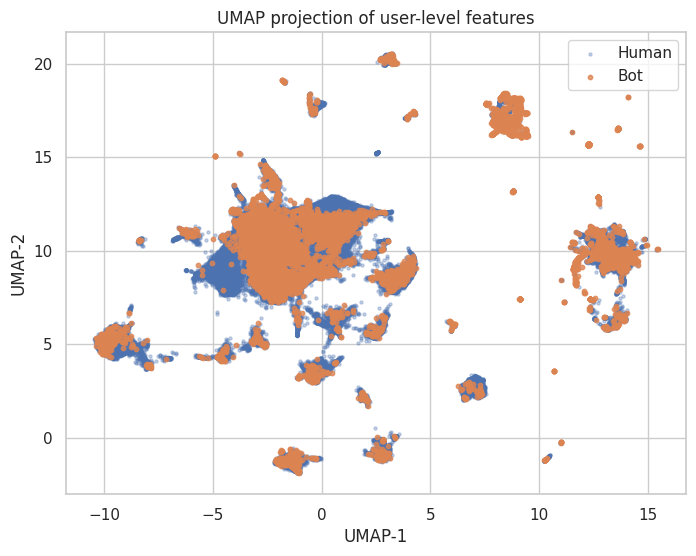

In [ ]:
exclude_cols = [
    "id",
    "description",
    "description_normalized",
    "desc_embedding",
    "name",
    "username",
    "label"
    ]

X = user_features_2.drop(columns=exclude_cols)

X = X.select_dtypes(include=[bool, np.number])
y = user_features["label"]

X = (
    X.replace([np.inf, -np.inf], np.nan)
     .fillna(0)
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# humans first
mask_human = y == 0
plt.scatter(
    X_umap[mask_human, 0],
    X_umap[mask_human, 1],
    s=5,
    alpha=0.3,
    label="Human"
)

# bots on top
mask_bot = y == 1
plt.scatter(
    X_umap[mask_bot, 0],
    X_umap[mask_bot, 1],
    s=10,
    alpha=0.8,
    label="Bot"
)

plt.legend()
plt.title("UMAP projection of user-level features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()